In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import cv2 as cv
from sklearn.cluster import KMeans
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns, os
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Input, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

In [2]:
def plot_random_images(generator, num_images=20):
    # Get a batch of data from the generator
    images, labels = next(generator)

    # Get random indices for selecting images
    random_indices = np.random.choice(images.shape[0], num_images, replace=False)

    # Plot the selected images
    fig, axs = plt.subplots(4, 5, figsize=(15, 12))
    fig.suptitle('Random 20 Images from the Generator', fontsize=16)

    for i, ax in enumerate(axs.flatten()):
        index = random_indices[i]
        image = images[index]
        label = labels[index]

        # Display the image
        ax.imshow(image)
        ax.set_title(f'Class: {np.argmax(label)}')
        ax.axis('off')

    plt.show()
    
def count_images_per_class(generator):
    class_counts = {class_name: 0 for class_name in generator.class_indices}
    
    for i in range(len(generator.classes)):
        class_index = generator.classes[i] 
        class_name = list(generator.class_indices.keys())[class_index] 
        class_counts[class_name] += 1  

    return class_counts

def visualize_per_class(categories, values):
    colors = ['green', 'red', 'orange']
    plt.bar(categories, values, color=colors)
    plt.xlabel('Kategori')
    plt.ylabel('Jumlah')
    plt.title('Correct Counts Data')
    plt.show()

Found 1402 images belonging to 3 classes.


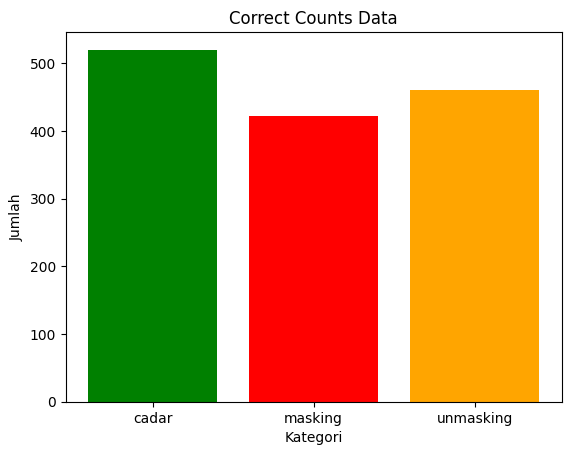

In [3]:
paths = '/kaggle/input/d/afthesis/result-preprocess-v2/new_result_v2'
original_data = ImageDataGenerator(rescale=1./255)
full_data = original_data.flow_from_directory(paths, target_size = (224, 224), batch_size = 32, class_mode="categorical", shuffle=False)
train_class_counts = count_images_per_class(full_data)
visualize_per_class(train_class_counts.keys(), train_class_counts.values())

In [4]:
original_data = ImageDataGenerator(rescale=1./255)
data_fully = original_data.flow_from_directory(paths, target_size = (224, 224), batch_size = 32, class_mode="categorical", shuffle=False)
filenames = data_fully.filenames
labels = data_fully.labels
class_mapping = {value: str(key) for key, value in data_fully.class_indices.items()}
labels = [class_mapping[label] for label in labels]
filenames[:5], labels[:5]

Found 1402 images belonging to 3 classes.


(['cadar/cropped_class_0_1038.jpg',
  'cadar/cropped_class_0_1060.jpg',
  'cadar/cropped_class_0_1108.jpg',
  'cadar/cropped_class_0_1181.jpg',
  'cadar/cropped_class_0_1217.jpg'],
 ['cadar', 'cadar', 'cadar', 'cadar', 'cadar'])

In [5]:
train_filenames, test_filenames, train_labels, test_labels = train_test_split(
    filenames, labels, test_size=0.2, random_state=42)
val_filenames, test_filenames, val_labels, test_labels = train_test_split(
    test_filenames, test_labels, test_size=0.5, random_state=42)

# Create DataFrames for training and testing
train_df = pd.DataFrame({'filename': train_filenames, 'class': train_labels})
val_df = pd.DataFrame({'filename': val_filenames, 'class': val_labels})
test_df = pd.DataFrame({'filename': test_filenames, 'class': test_labels})

# Create separate generators for training and testing using flow_from_dataframe
train_data = original_data.flow_from_dataframe(train_df, directory=paths, target_size=(224, 224),
                                           batch_size=32, class_mode="categorical",
                                           shuffle=False, seed=42)

val_data = original_data.flow_from_dataframe(val_df, directory=paths, target_size=(224, 224),
                                          batch_size=32, class_mode="categorical",
                                          shuffle=False)

test_data = original_data.flow_from_dataframe(test_df, directory=paths, target_size=(224, 224),
                                          batch_size=32, class_mode="categorical",
                                          shuffle=False)

Found 1121 validated image filenames belonging to 3 classes.
Found 140 validated image filenames belonging to 3 classes.
Found 141 validated image filenames belonging to 3 classes.


In [6]:
def visualize_images(original, segment):
    # Create a figure to display the images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original) 
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(segment, cmap='gray')
    plt.title('Segmentation with KNN')
    plt.axis('off')

    # Show
    plt.tight_layout()
    plt.show()

def load_image(image_path):
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 
    return img

def segment_images_kmean(image, n_clusters):
    pixels = image.reshape(-1, 1)  

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pixels)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_.astype(int) 

    segmented_image = centers[labels].reshape(image.shape)  
    return segmented_image

def image_preprocessing(image_path):
    img = load_image(image_path)
    img_segmented = segment_images_kmean(img, 5)
    
    return img_segmented

def preprocess_and_save_images(input_dir, filenames, classes, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for i in range(len(classes)):
        myclass = 'cadar' if classes[i] == 0 else 'masking' if classes[i] == 1 else 'unmasking'
        class_path = os.path.join(input_dir, myclass)
        if os.path.isdir(class_path): 
            output_class_path = os.path.join(output_dir, myclass)
            os.makedirs(output_class_path, exist_ok=True)  
            
            img_path = os.path.join(input_dir, filenames[i])
            # print(img_path)
            preprocessed_img = image_preprocessing(img_path)

            # Save
            output_img_path = os.path.join(output_dir, filenames[i])
            cv.imwrite(output_img_path, preprocessed_img)
                
    print(f"Preprocessing complete. Preprocessed images saved in {output_dir}")


In [7]:
output_dir = '/kaggle/working/new_result_v2'
img_dir = '/kaggle/input/d/afthesis/result-preprocess-v2/new_result_v2'
preprocess_and_save_images(img_dir, val_data.filenames, val_data.classes, output_dir)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

Preprocessing complete. Preprocessed images saved in /kaggle/working/new_result_v2


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [8]:
# import shutil
# shutil.make_archive('/kaggle/working/test_new_result_v2', 'zip', '/kaggle/working/test_new_result_v2')

In [9]:
val_dir = '/kaggle/working/new_result_v2'
full_val_original = ImageDataGenerator(rescale=1./255)

# Menggunakan flow_from_directory untuk mendapatkan class names
val_fully = full_val_original.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 140 images belonging to 3 classes.


In [10]:
train_data.image_shape

(224, 224, 3)

In [11]:
start_lr = 0.0001
min_lr = 0.000001
max_lr = 0.001
rampup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Define the scheduling function
def schedule(epoch):
  def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
    if epoch < rampup_epochs:
      lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
      lr = max_lr
    else:
      lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    return lr
  return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
scheduler_lr = LearningRateScheduler(schedule, verbose=True)

In [12]:
tf.keras.backend.clear_session()

In [37]:
def modeling(img_width, img_height, training, validation):
    # Distribution strategy
    strategy = tf.distribute.MirroredStrategy()

    with strategy.scope():
        # Input layer
        inputs = Input(shape=(img_width, img_height, 3))

        # Convolution block 1
        conv1 = Conv2D(filters=32, kernel_size=(3, 3), strides=(2,2), activation='relu', kernel_regularizer=l2(0.001))(inputs)
        conv1 = BatchNormalization()(conv1)
        conv1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        # Convolution block 2
        conv2 = Conv2D(filters=64, kernel_size=(3, 3), strides=(2,2), activation='relu', kernel_regularizer=l2(0.001))(conv1)
        conv2 = BatchNormalization()(conv2)
        conv2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        # Convolution block 3
        conv3 = Conv2D(filters=256, kernel_size=(3, 3), strides=(2,2), activation='relu', kernel_regularizer=l2(0.001))(conv2)
        conv3 = BatchNormalization()(conv3)
        conv3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        # Convolution block 4 with global pooling
        conv4 = Conv2D(filters=512, kernel_size=(3, 3), strides=(2,2), activation='relu', kernel_regularizer=l2(0.001))(conv3)
        conv4 = BatchNormalization()(conv4)
        conv4 = GlobalAveragePooling2D()(conv4)  # Global pooling instead of MaxPooling2D

        # Flatten and dense layers
        x = Flatten()(conv4)
        x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = Dropout(0.5)(x)
        x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = Dropout(0.5)(x)
        x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = Dropout(0.5)(x)
        outputs = Dense(3, activation='softmax')(x)  # Assuming 3 classes

        # Build and compile model
        model = Model(inputs=inputs, outputs=outputs)
        model.summary()

        # Compile the model
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        # Add early stopping and learning rate scheduler
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

        # Train model with augmented data
        history = model.fit(training, validation_data=validation, epochs=100, callbacks=[early_stopping, lr_scheduler])
        
        return history

In [38]:
history = modeling(224, 224, train_data, val_fully)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 111, 111, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 27, 27, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 6, 6, 256)      │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 1, 1, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 1, 1, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,523,395 (5.81 MB)

 Trainable params: 1,521,667 (5.80 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - accuracy: 0.3887 - loss: nan - val_accuracy: 0.3571 - val_loss: 2.1604 - learning_rate: 1.0000e-04
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.4449 - loss: nan - val_accuracy: 0.4571 - val_loss: 2.1086 - learning_rate: 1.0000e-04
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.4544 - loss: nan - val_accuracy: 0.4571 - val_loss: 2.0798 - learning_rate: 1.0000e-04
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.4735 - loss: nan - val_accuracy: 0.4571 - val_loss: 2.0422 - learning_rate: 1.0000e-04
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.4776 - loss: nan - val_accuracy: 0.4571 - val_loss: 2.0341 - learning_rate: 1.0000e-04
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.5198 - loss: nan - val_accuracy: 0.4714 - val_loss: 1.9955 - learning_rate: 1.0000e-04
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.5255 - loss: n

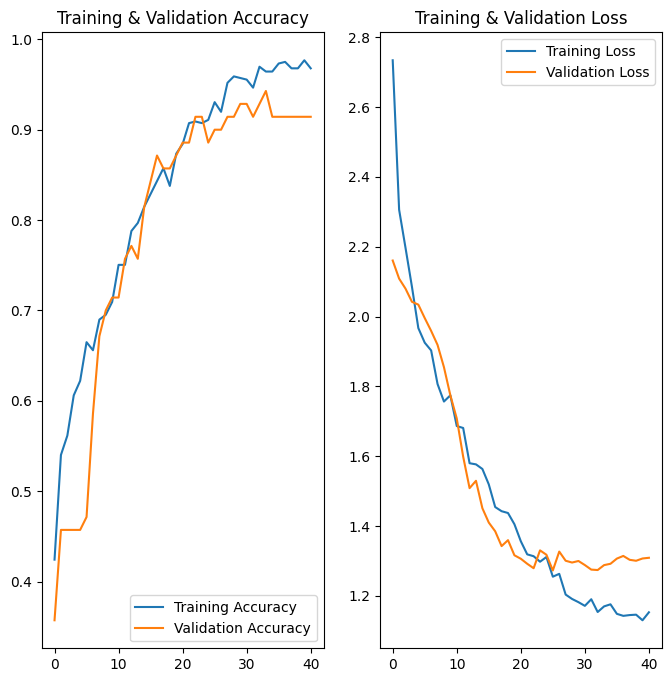

In [39]:
def showAllValueOfHistory(history, epochs_range):
    epochs_range = list(range(epochs_range))
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training & Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training & Validation Loss')
    return plt.show()

showAllValueOfHistory(history, 41)

In [40]:
history.model.save('/kaggle/working/model_26.h5')